In [ ]:
!pip install -q gdown

# Replace with your actual file ID
file_id = "1ZAugiwySVQxz7WJogd3eRJOU76uWRILZ"
!gdown https://drive.google.com/uc?id={file_id}


Downloading...
From (original): https://drive.google.com/uc?id=1ZAugiwySVQxz7WJogd3eRJOU76uWRILZ
From (redirected): https://drive.google.com/uc?id=1ZAugiwySVQxz7WJogd3eRJOU76uWRILZ&confirm=t&uuid=09ee571e-c548-4c28-9931-4d355f7db8b2
To: /content/vgg_tune_model.h5
100% 202M/202M [00:02<00:00, 87.2MB/s]


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('vgg_tune_model.h5')


In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

def plot_prediction(model, img_path, class_names):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    idx = np.argmax(preds)
    confidence = preds[0][idx]

    plt.imshow(img)
    plt.title(f"Prediction: {class_names[idx]} ({confidence:.2f})")
    plt.axis('off')
    plt.show()

    return class_names[idx]



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


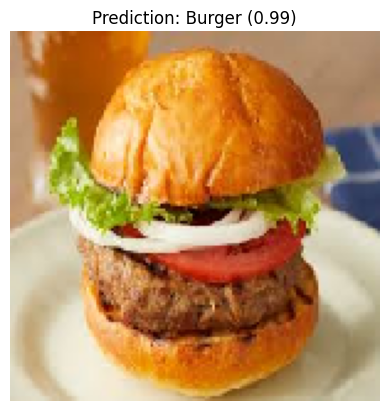

In [ ]:
class_names = ['Burger', 'Kapao', 'Soup', 'Salad', 'PorkFriedRice', 'Steak', 'KhaoTomGoong', 'Noodles', 'Chicken-Rice']
predicted_food = plot_prediction(model, 'Burger.jpg', class_names)


In [ ]:
!pip install langchain-google-genai

In [ ]:
import pandas as pd
history_df = pd.DataFrame()

In [ ]:
# Food input

input_text = predicted_food

In [ ]:
# This is for Advice

input_text = "Advice"

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
from google.colab import userdata
import pandas as pd
import time

# SCHEMA
nutrition_schema = [
    ResponseSchema(name="Food name", description="Name of the food (No Additional explanation)"),
    ResponseSchema(name="Calories(kcal)", description="Calories of the food in kcal"),
    ResponseSchema(name="Fat(g)", description="Fat in grams"),
    ResponseSchema(name="Protein(g)", description="Protein in grams"),
    ResponseSchema(name="Carbohydrates(g)", description="Carbohydrates in grams"),
]

advice_schema = [
    ResponseSchema(name="Food name", description="Name of the recommended food (No Additional explanation)"),
    ResponseSchema(name="Reasons", description="Reasons why this food is recommended"),
]

nutrition_parser = StructuredOutputParser.from_response_schemas(nutrition_schema)
advice_parser = StructuredOutputParser.from_response_schemas(advice_schema)

# PROMPTS
prompt_nutrition = ChatPromptTemplate.from_template("""
You are an AI that answers nutrition information about food (only numbers value for nutrition).

Answer ONLY in this JSON format:
{nutrition_format}

Food name: {input}
""")

prompt_advice = ChatPromptTemplate.from_template("""
You are an AI that gives meal advice based on user history.

Here is the history of foods the user ate:
{history}

Step 1: List all food names above → These are FORBIDDEN for recommendation.
Step 2: Think about what nutrients user ate too much or too little.
Step 3: Recommend a NEW dish not in history (very common dish that even children know).

Answer ONLY in this JSON format:
{advice_format}
""")

# MODEL
llm = ChatGoogleGenerativeAI(
    google_api_key=userdata.get('google_api_key'),
    model="gemini-2.0-flash",
    temperature=0
)

nutrition_chain = prompt_nutrition | llm
advice_chain = prompt_advice | llm

history_text = ""
for _, row in history_df.tail(3).iterrows():
    history_text += f'{row["Food name"]}\n'

# PROCESS
if input_text.lower() == "advice":

    def get_valid_advice():
        while True:
            response = advice_chain.invoke({
                "history": history_text,
                "advice_format": advice_parser.get_format_instructions()
            })

            parsed_data = advice_parser.parse(response.content)
            recommended_dish = parsed_data["Food name"].strip()

            if recommended_dish in history_d  f["Food name"].values:
                time.sleep(1)
                continue
            else:
                return parsed_data

    parsed_data = get_valid_advice()
    print(parsed_data)
else:
    response = nutrition_chain.invoke({
        "input": input_text,
        "nutrition_format": nutrition_parser.get_format_instructions()
    })

    parsed_data = nutrition_parser.parse(response.content)
    df = pd.DataFrame([parsed_data])
    history_df = pd.concat([history_df, df], ignore_index=True)

    print(history_df)

{'Food name': 'Pizza', 'Reasons': "Based on the user's history of eating Kapao and Burger, it seems they enjoy savory and relatively quick meals. Pizza offers a balance of carbohydrates, protein, and fats, and can be customized with various toppings to provide a wider range of nutrients that might be lacking in their current diet. It's also a widely accessible and familiar food."}
